In [150]:
# Importing Libraries
import torch
import numpy as np
import torchvision
from torch.utils.data import DataLoader
from torch import nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch.nn import functional as F
from matplotlib import pyplot as plt
import random

In [151]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # checking device type
print(device)

cuda


In [152]:
torch.cuda.empty_cache()

In [153]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encode_sequence = nn.Sequential(
            #Convolutional Layer
            nn.Conv2d(1, 8, kernel_size=3, padding= 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.Sigmoid(),

        )
        self.decode_sequence = nn.Sequential(
            #Convolutional Layer
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, X):
        encoded_data = self.encode_sequence(X)
        decoded_data = self.decode_sequence(encoded_data)
        return decoded_data

In [154]:
model = autoencoder().to(device)
learning_rate = 0.001
num_epoch = 3
batch_size = 128
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [155]:
train_dataset = datasets.MNIST(root = './dataset', train= True, transform = transforms.ToTensor(), download = True)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_dataset = datasets.MNIST(root = './dataset', train= False, transform = transforms.ToTensor(), download = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)

In [156]:
def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [157]:
losses = []
for epoch in range(num_epoch): # number of iterations
    for i, (data, targets) in enumerate(train_loader , 0): # one min-batch goes through each iteration of size 64
        # Converting to acceptable format
        data = data.to(device=device)

        noise_data=add_noise(data)
        
        # Forward pass
        output = model(noise_data)
        loss = criterion(output, data)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #to convert cuda type loss to numpy type
        loss=loss.detach().cpu().numpy()
        losses.append(loss)

In [158]:
#Reshaping the data

print(data.shape, output.shape)

torch.Size([96, 1, 28, 28]) torch.Size([96, 1, 28, 28])


In [159]:
#To convert cuda tensor to numpy array
data= data.detach().cpu().numpy()
noise_data= noise_data.detach().cpu().numpy()
output = output.detach().cpu().numpy()

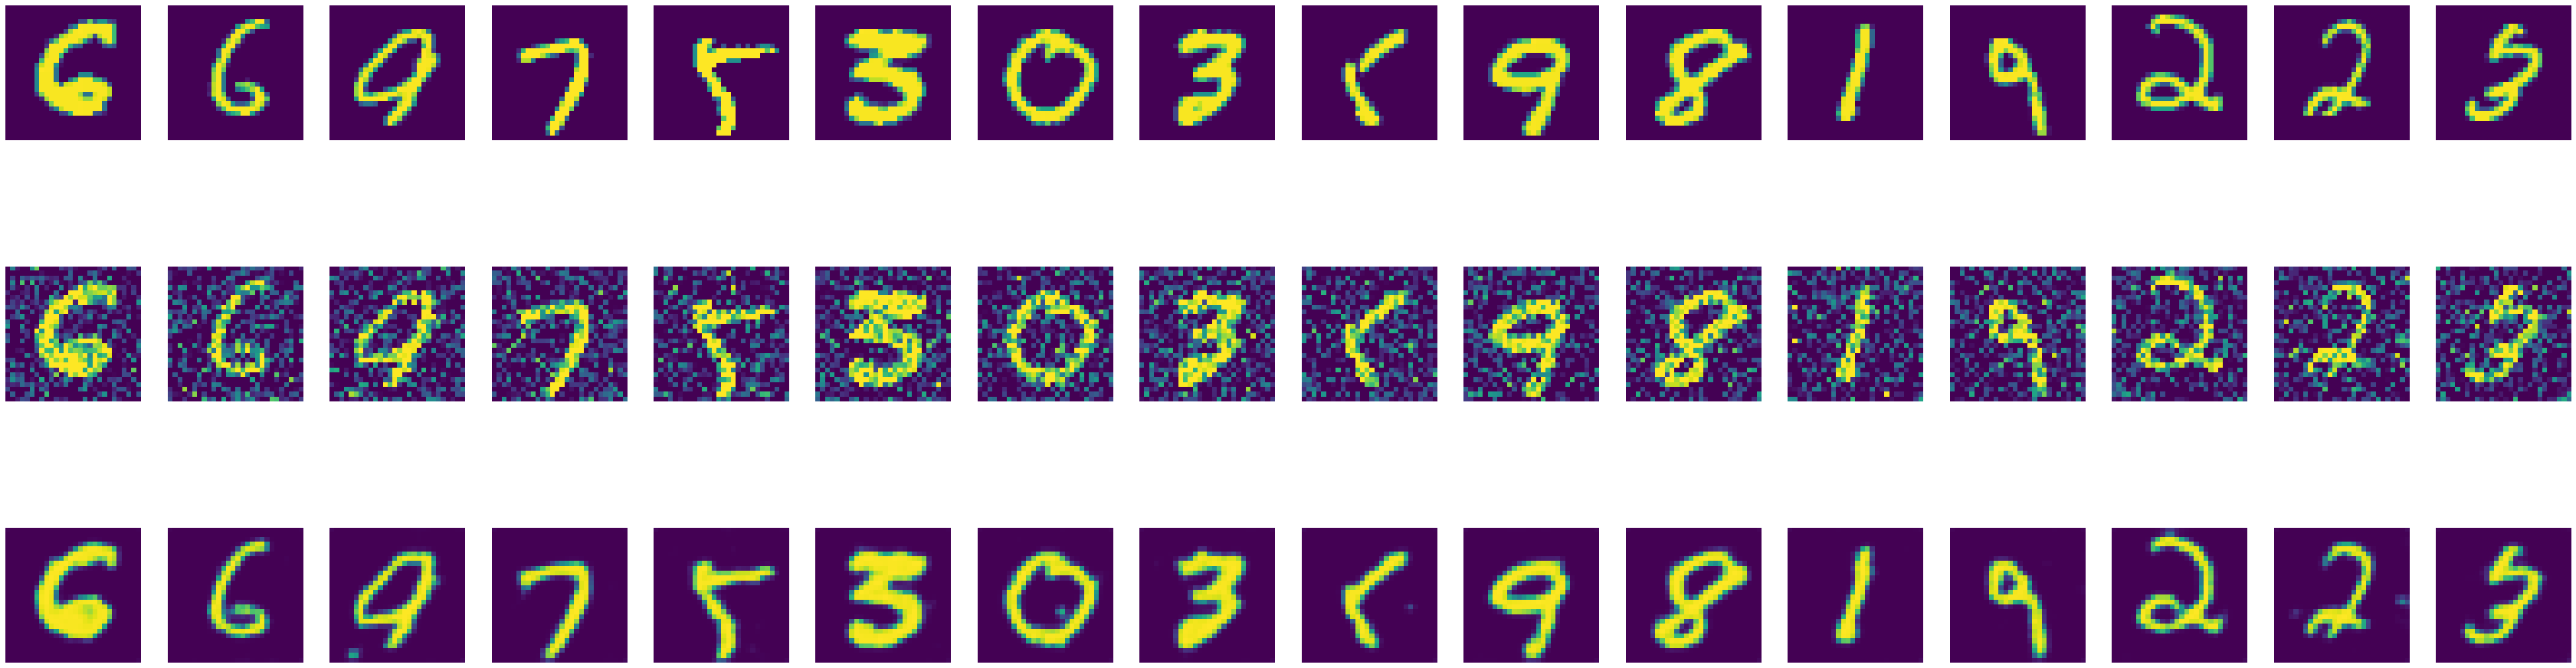

In [160]:
plt.figure(figsize = (60,300))

for i in range(16):
    plt.subplot(48,16,i+1)
    plt.imshow(data[i].reshape(28,28))
    plt.axis('off')

    plt.subplot(48,16,i + 17)
    plt.imshow(noise_data[i].reshape(28,28))
    plt.axis('off')

    plt.subplot(48,16,i + 33)
    plt.imshow(output[i].reshape(28,28))
    plt.axis('off')

plt.show()

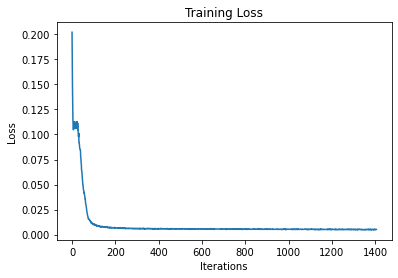

In [161]:
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

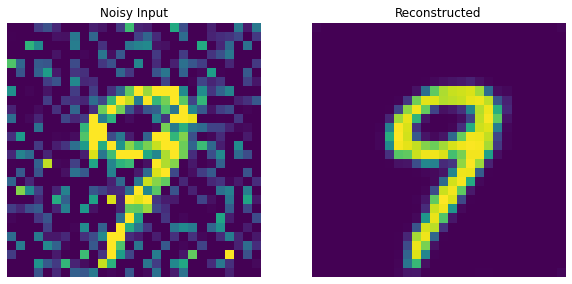

In [162]:
index= random.randint(0, len(test_dataset))

with torch.no_grad():
    data= test_dataset[index][0].view(1,1,28,28)
    data= data.to(device)

    noise_data=add_noise(data)

    output = model(noise_data)
    
    noise_data= noise_data.detach().cpu().numpy()
    
    data=data.detach().cpu().numpy()

    output = output.detach().cpu().numpy()

    plt.figure(figsize = (10,25))

    plt.subplot(1,2,1)
    plt.title('Noisy Input')
    plt.imshow(noise_data[0].reshape(28,28))
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Reconstructed')
    plt.imshow(output[0].reshape(28,28))
    plt.axis('off')
    plt.show()